In [1]:
import pandas as pd
import datetime
import json
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from matplotlib.image import imread
from keras.preprocessing import image
from sklearn.metrics import r2_score
import seaborn as sns
import helper as hlp

Using TensorFlow backend.


In [0]:
with open('train_test.json', 'r') as file1:
  data = json.load(file1)

stocks = [i for i in data.keys()]


In [0]:
processed_data = {}
data_keys= ['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']
target_keys = ['Low_1_under_bin', 'Low_1_-0.1', 'Low_1_-0.09', 'Low_1_-0.08', 'Low_1_-0.07', 'Low_1_-0.06', 
               'Low_1_-0.05', 'Low_1_-0.04', 'Low_1_-0.03', 'Low_1_-0.02', 'Low_1_-0.01', 'Low_1_0.0',  'Low_1_over_bin']
for stock in stocks:
    x = []
    target = []
    dict_ = {}
    for i in data[stock]:
        row = np.array([i[key] for key in data_keys]).reshape(1,len(data_keys))
        
        x.append(row)
        row = np.array([i[key] for key in target_keys]).reshape(len(target_keys))
        target.append(row)
    length_ = (len(x)//25)*25
    dict_['Data'] = x[:length_]
    dict_['Target'] = target[:length_]
    processed_data[stock] = dict_

In [10]:
np.shape(processed_data[stocks[0]]['Data']), np.shape(processed_data[stocks[0]]['Target'])

((1475, 1, 6), (1475, 26))

In [0]:
for stock in stocks:
    length_ = len(processed_data[stock]['Data'])
    length_test = len(processed_data[stock]['Data'])//8
    test_start = length_- 25
    test_end = length_test+ test_start
    processed_data[stock]['data_1'] = np.array(processed_data[stock]['Data'][:test_start])
  
    processed_data[stock]['data_test'] = np.array(processed_data[stock]['Data'][test_start:])
    
    processed_data[stock]['target_1']  = np.array(processed_data[stock]['Target'][:test_start])
    
    processed_data[stock]['target_test'] = np.array(processed_data[stock]['Target'][test_start:])
    

In [12]:
np.shape(processed_data[stocks[0]]['data_1']), np.shape(processed_data[stocks[0]]['target_1']),
 

((1425, 1, 6), (1425, 26))

In [13]:
np.shape(processed_data[stocks[0]]['data_test']), np.shape(processed_data[stocks[0]]['target_test'])

((50, 1, 6), (50, 26))

In [0]:
model = models.Sequential()
model.add(layers.GRU(50, return_sequences=True, batch_input_shape=(25, 1,6), stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=True, stateful= True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "linear"))


In [0]:
model.load_weights('gru_stateful_1_30_19.h5')


In [0]:
new_model = models.Sequential()
new_model.add(layers.GRU(50, return_sequences=True, batch_input_shape=(25, 1,6), stateful= True))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.GRU(100, return_sequences=True, stateful= True))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.GRU(100, return_sequences=False))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.Dense(len(target_keys), activation = "softmax"))
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [25]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (25, 1, 50)               8550      
_________________________________________________________________
dropout_1 (Dropout)          (25, 1, 50)               0         
_________________________________________________________________
gru_2 (GRU)                  (25, 1, 100)              45300     
_________________________________________________________________
dropout_2 (Dropout)          (25, 1, 100)              0         
_________________________________________________________________
gru_3 (GRU)                  (25, 100)                 60300     
_________________________________________________________________
dropout_3 (Dropout)          (25, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (25, 26)                 

In [0]:
new_model.layers[0].set_weights(model.layers[0].get_weights())
new_model.layers[1].set_weights(model.layers[1].get_weights())
new_model.layers[2].set_weights(model.layers[2].get_weights())
new_model.layers[3].set_weights(model.layers[3].get_weights())
new_model.layers[4].set_weights(model.layers[4].get_weights())
new_model.layers[5].set_weights(model.layers[5].get_weights())

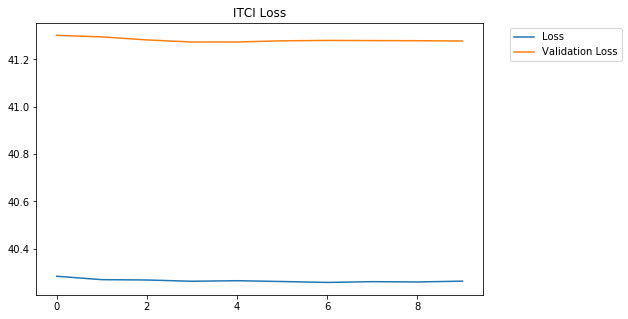

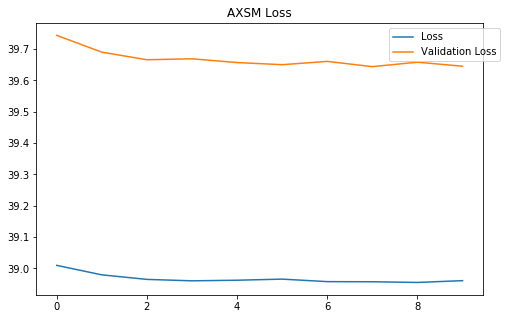

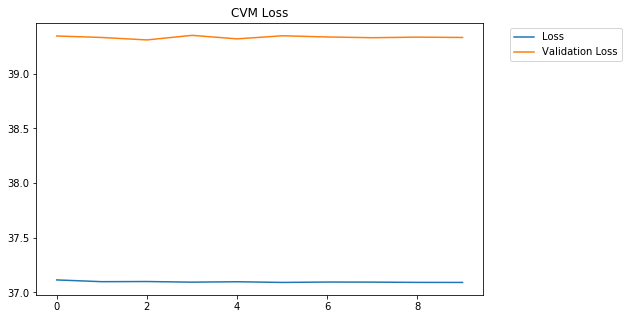

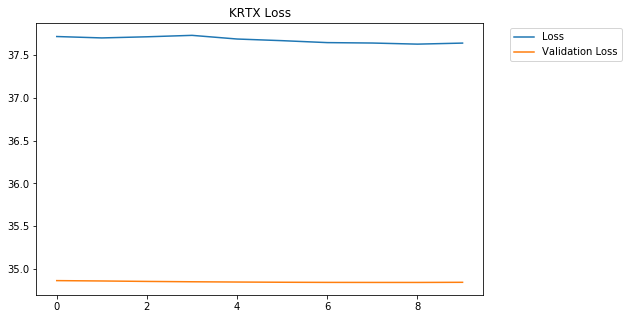

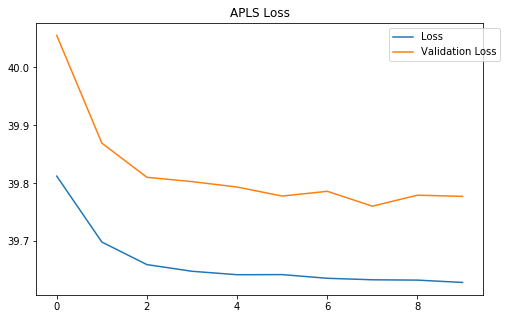

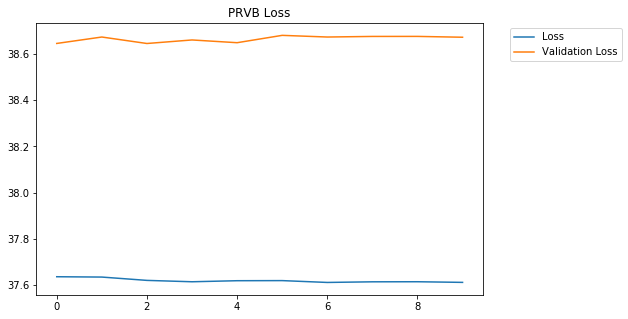

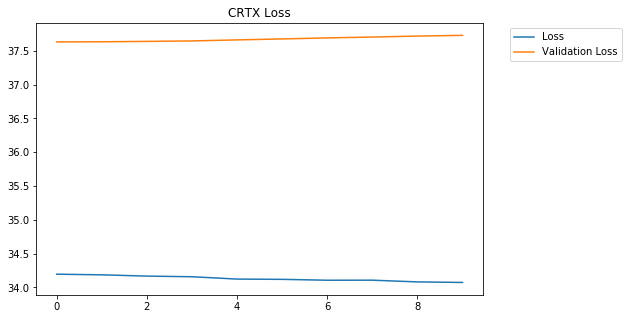

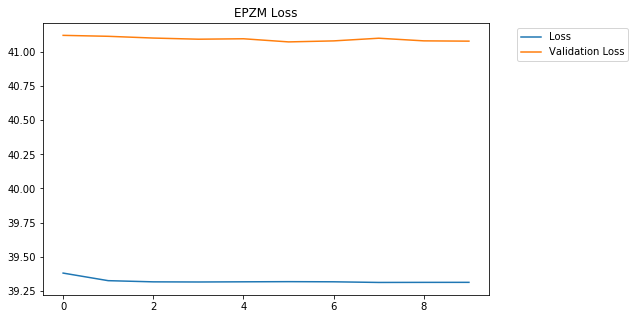

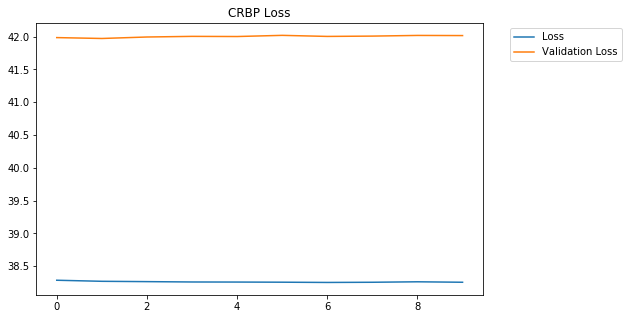

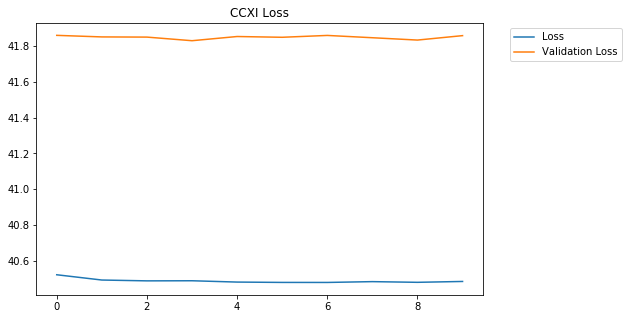

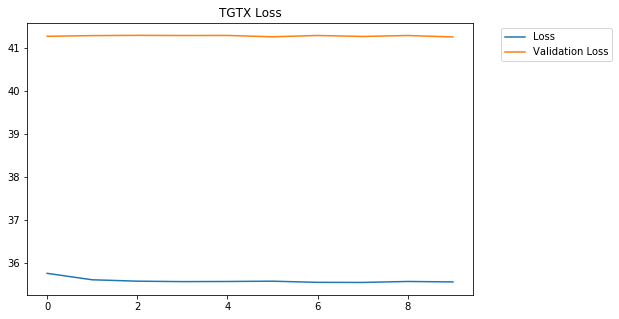

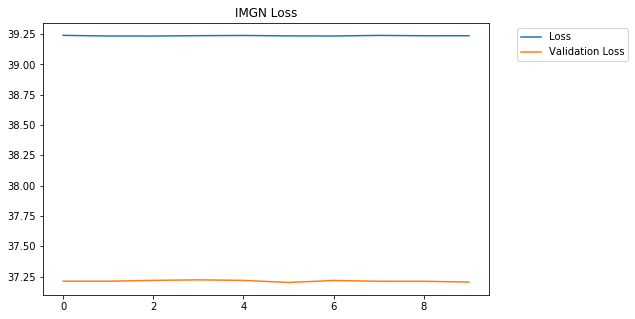

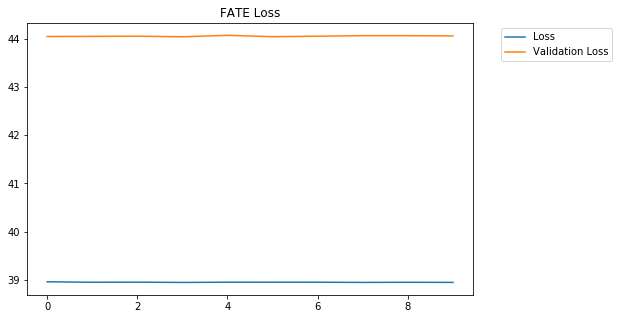

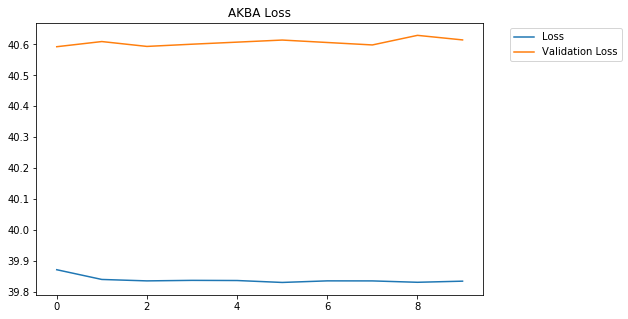

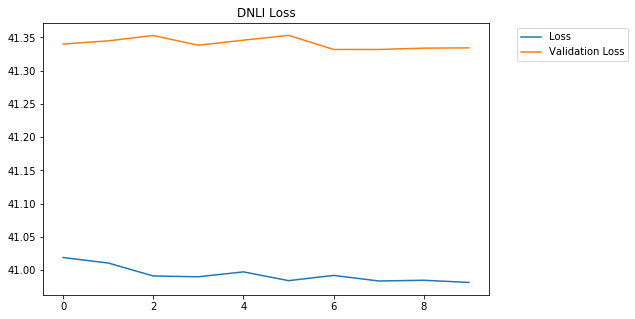

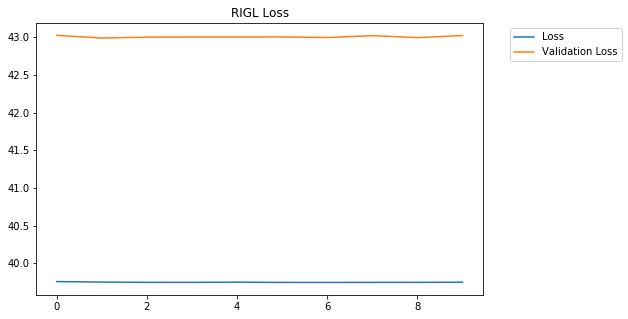

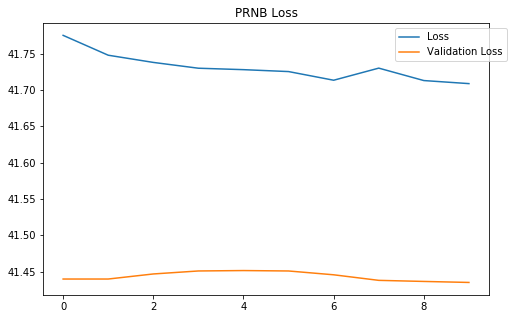

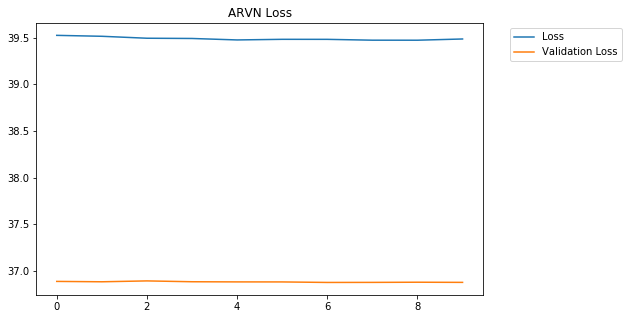

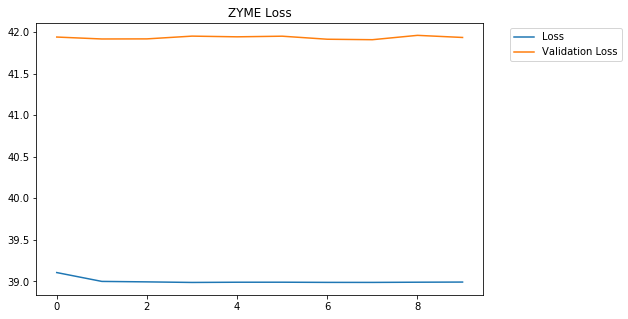

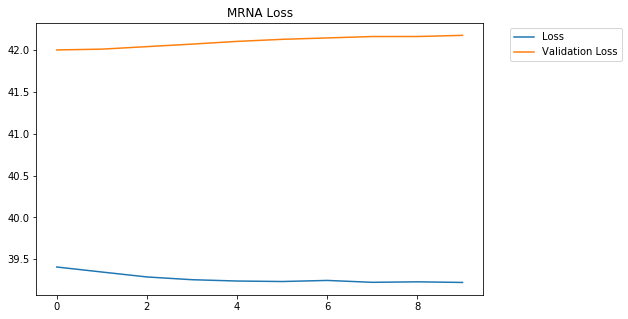

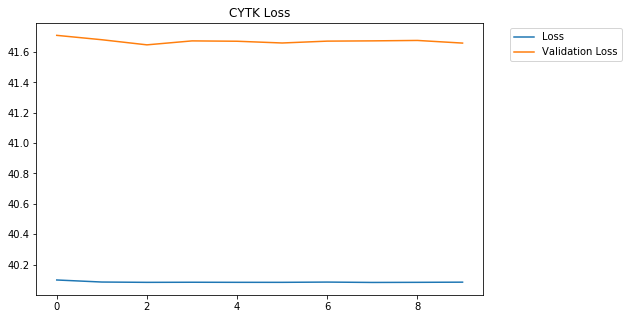

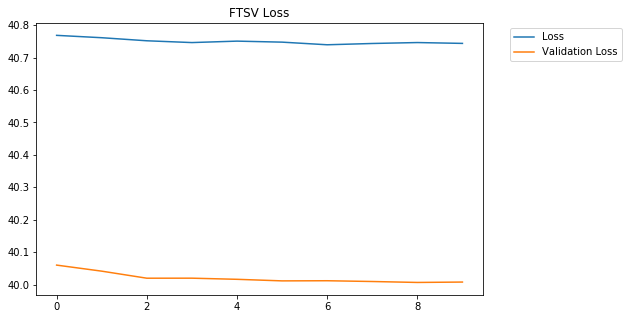

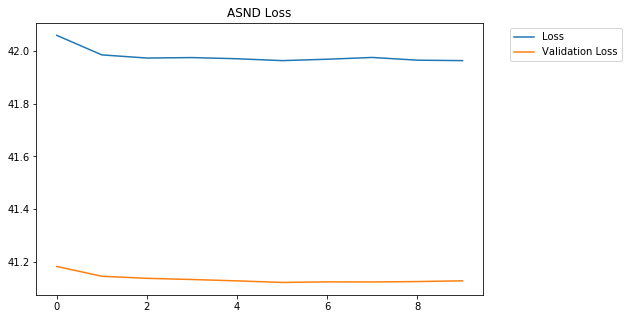

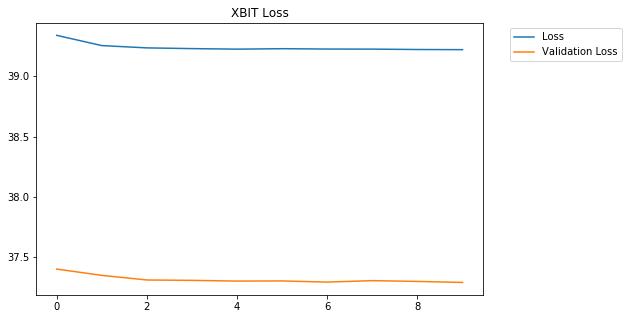

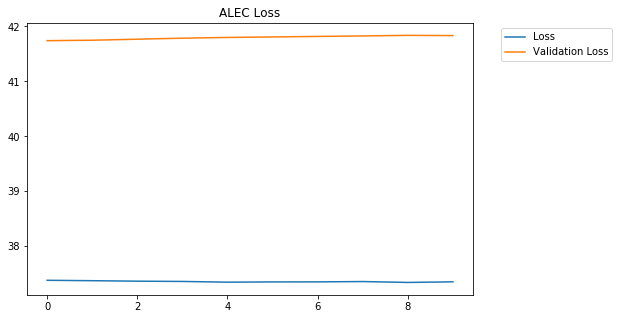

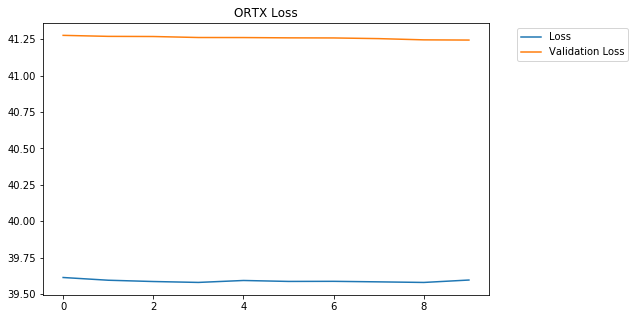

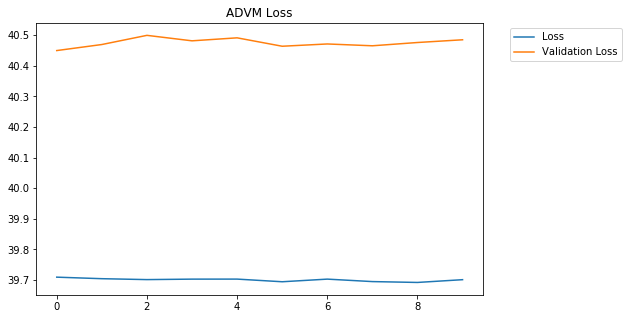

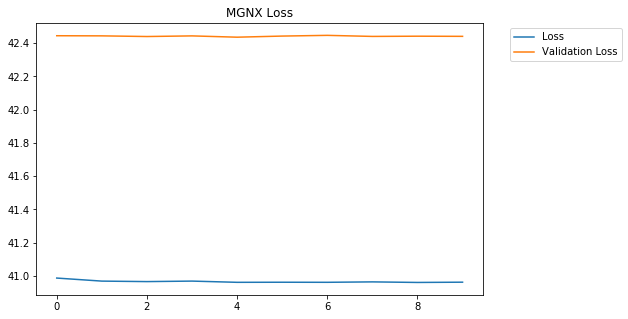

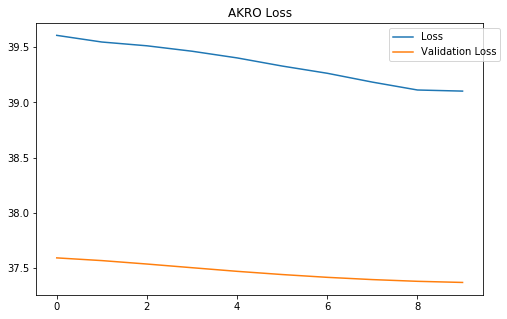

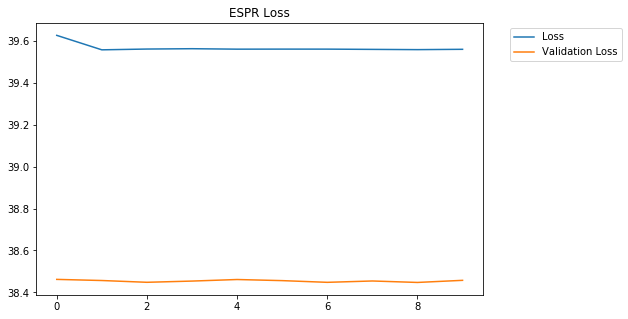

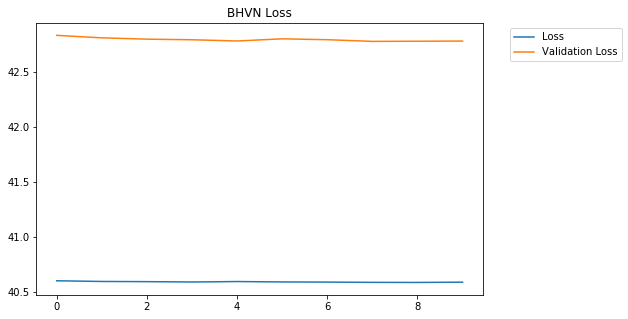

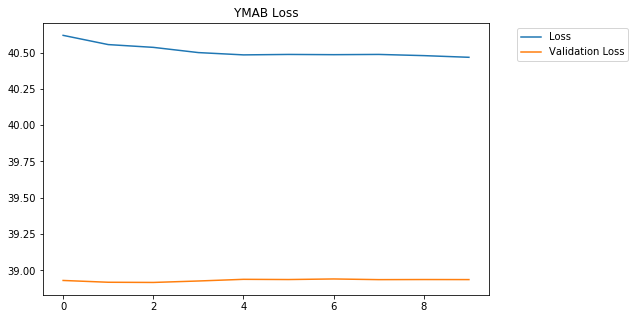

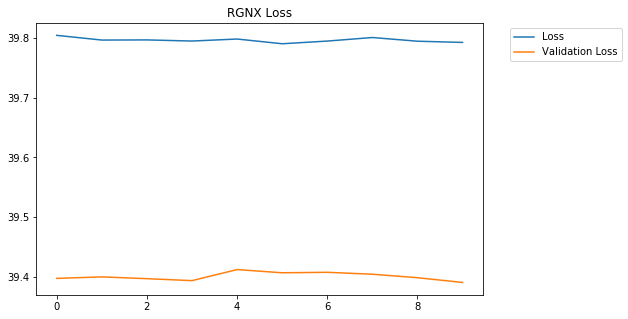

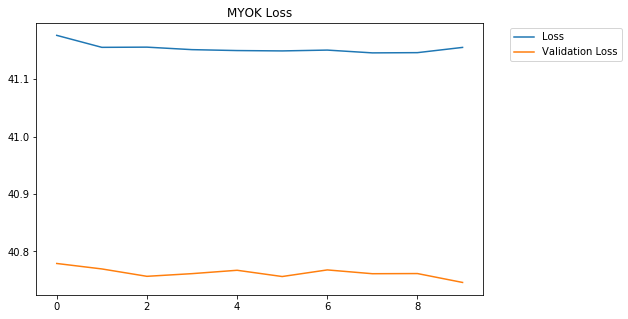

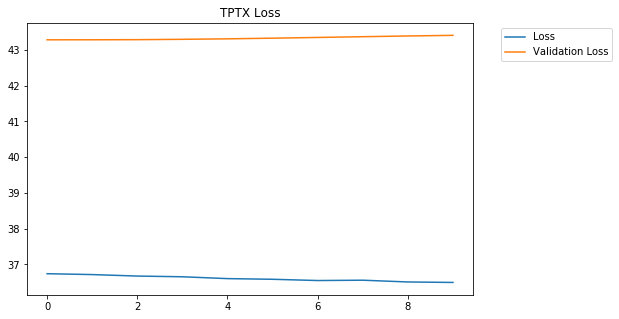

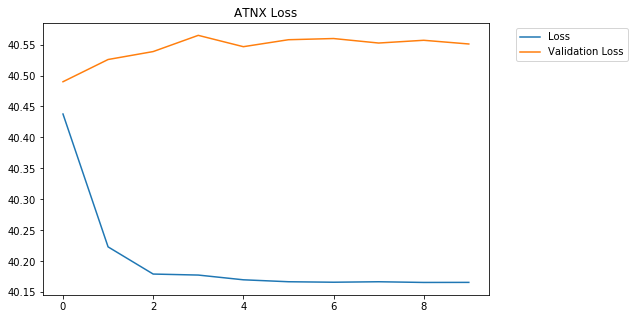

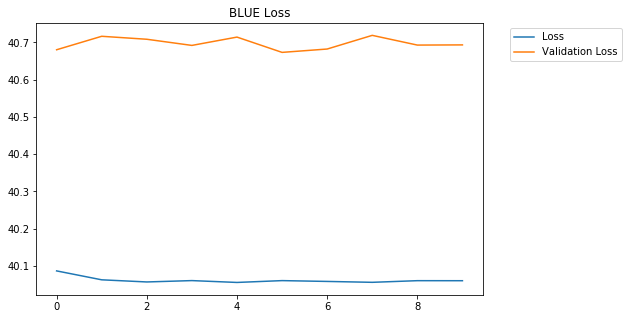

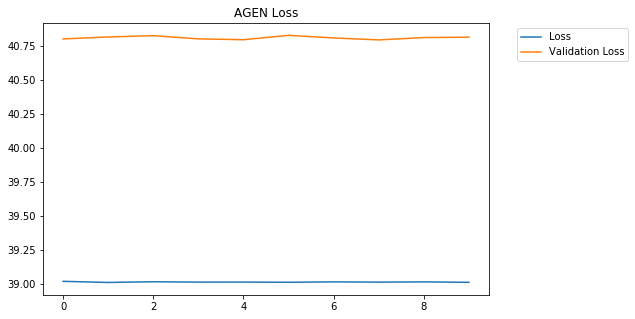

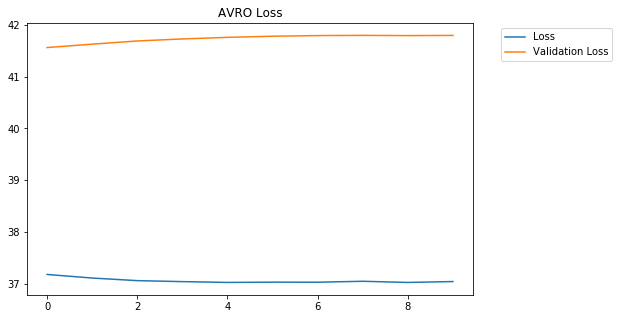

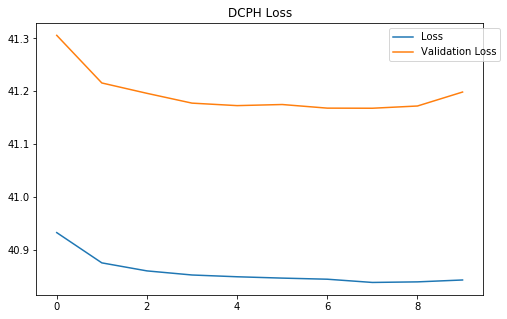

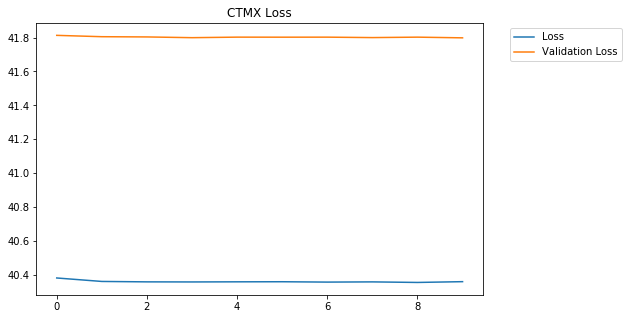

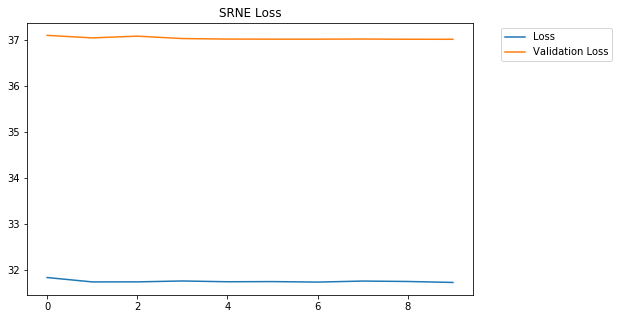

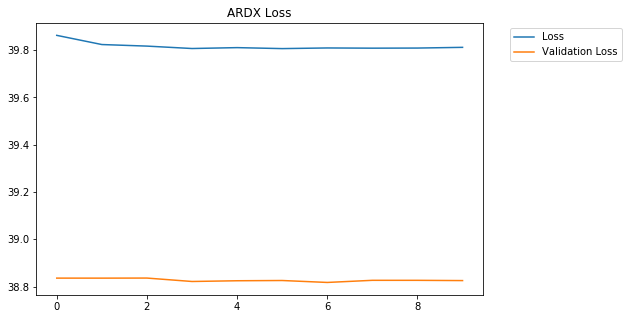

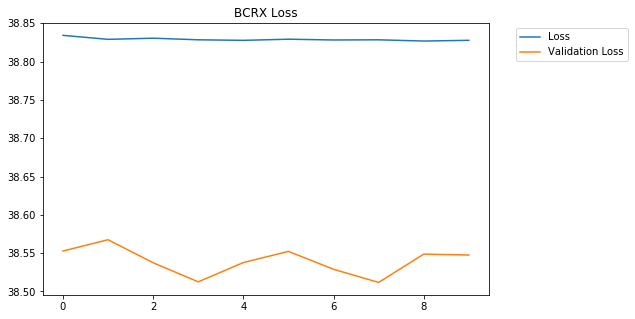

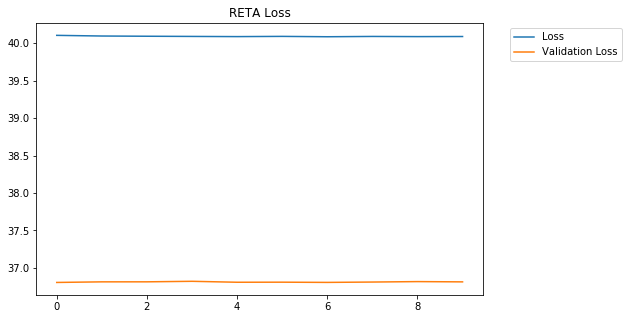

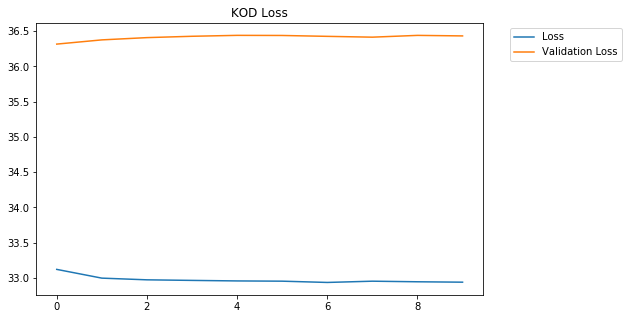

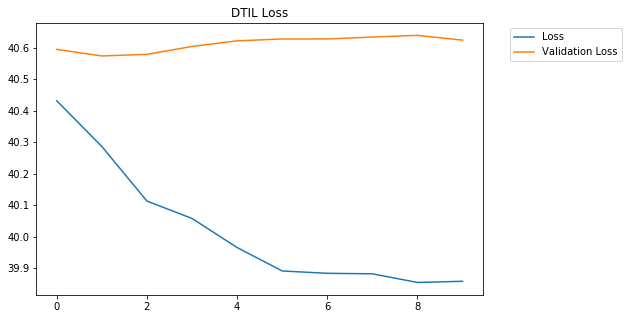

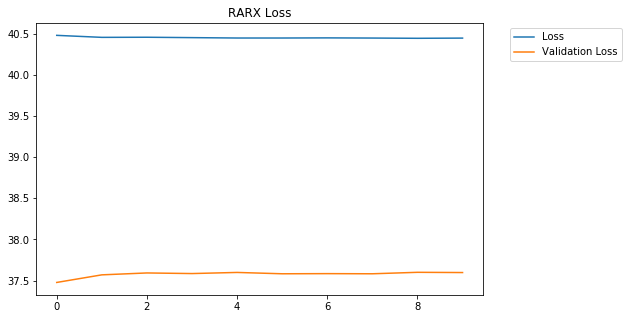

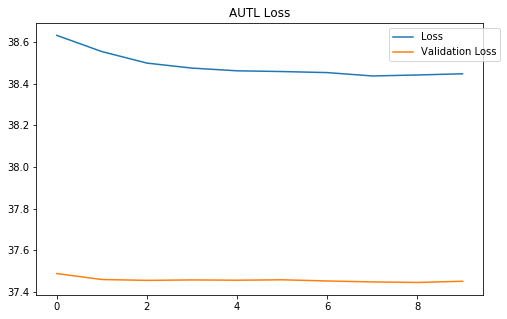

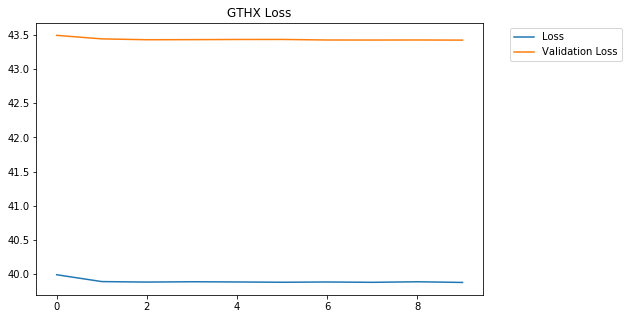

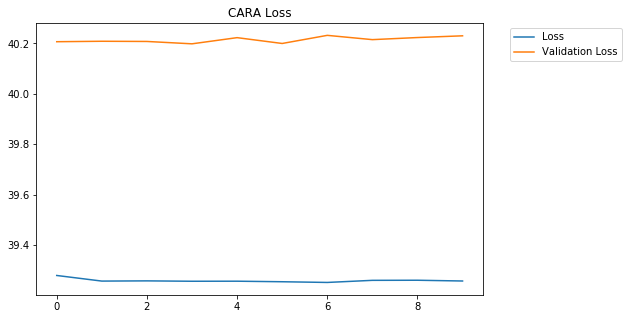

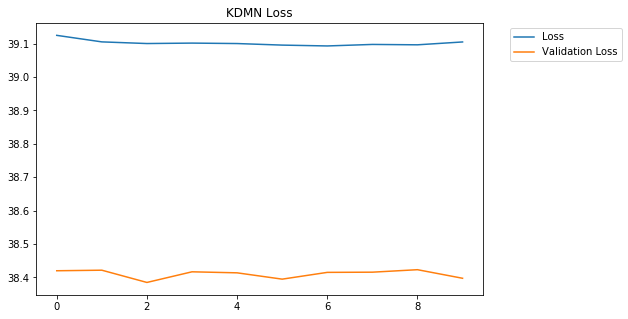

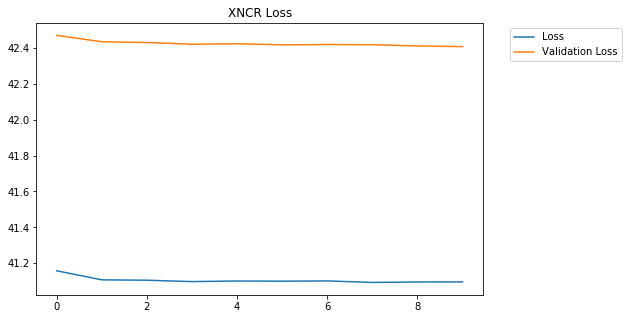

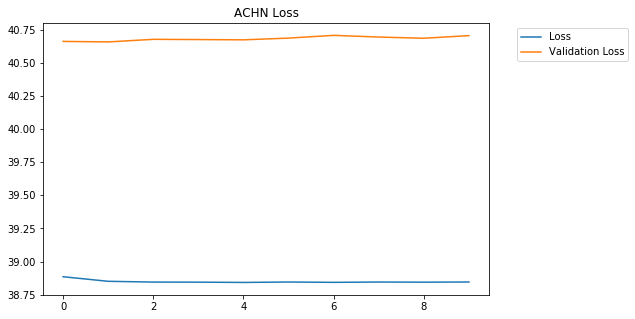

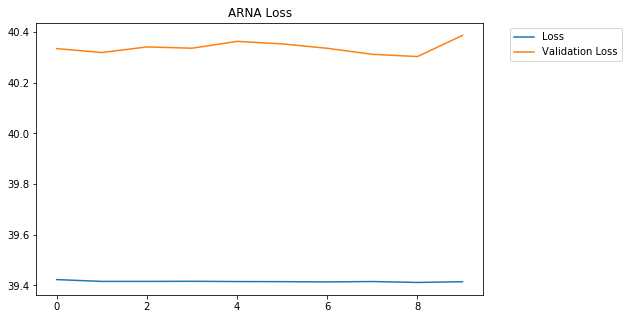

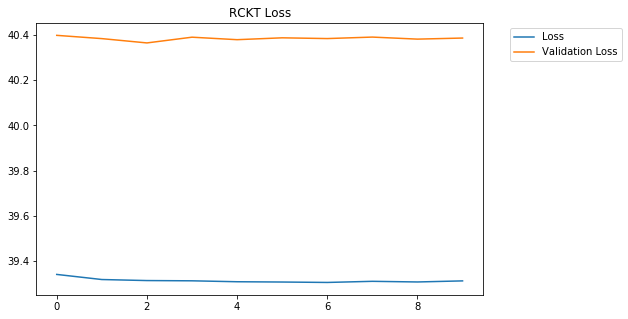

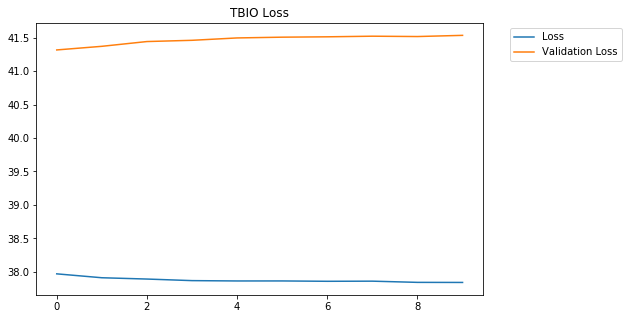

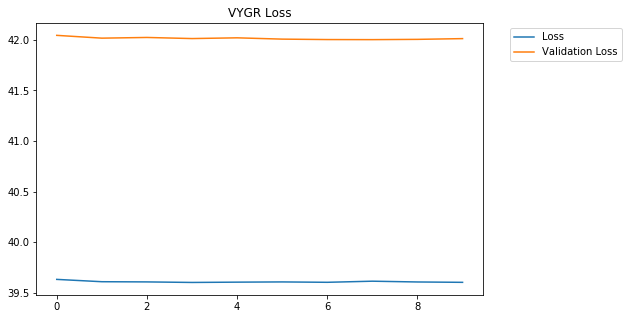

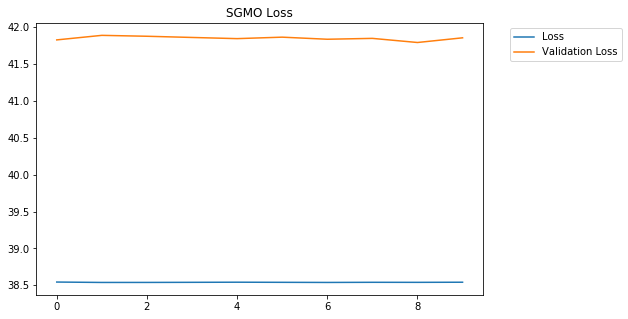

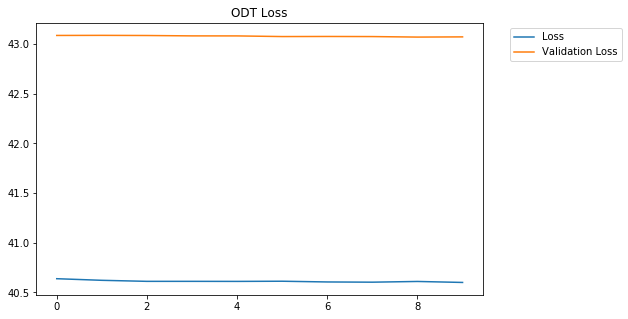

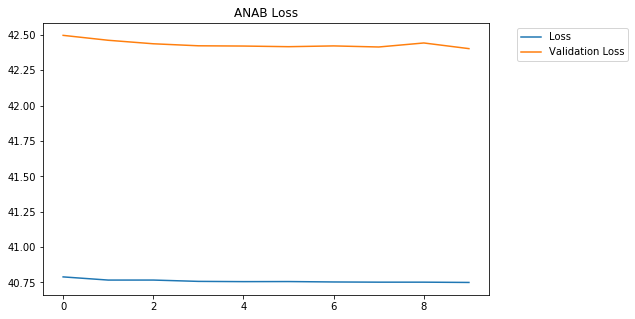

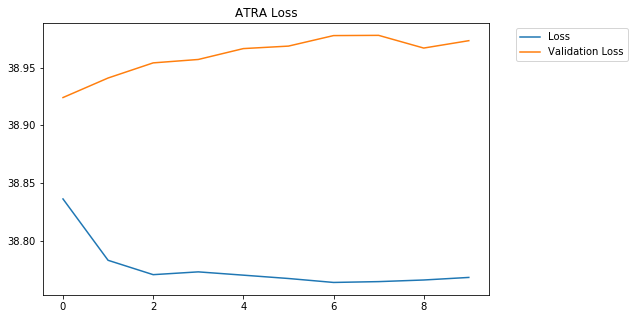

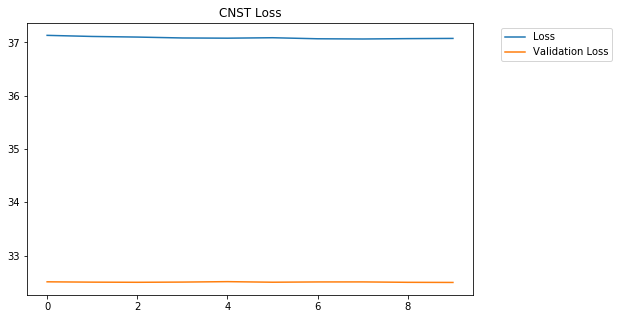

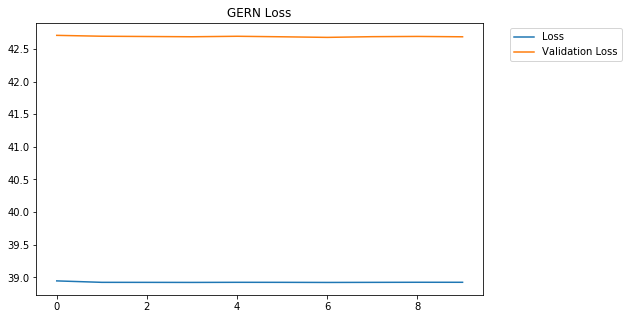

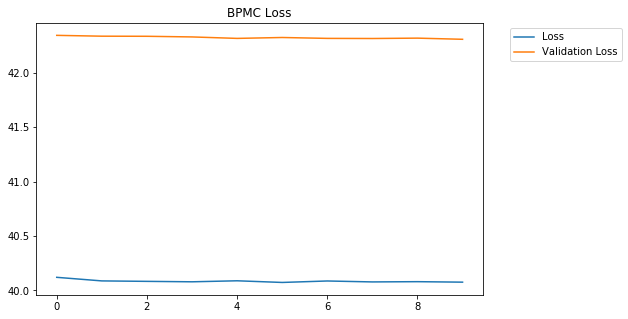

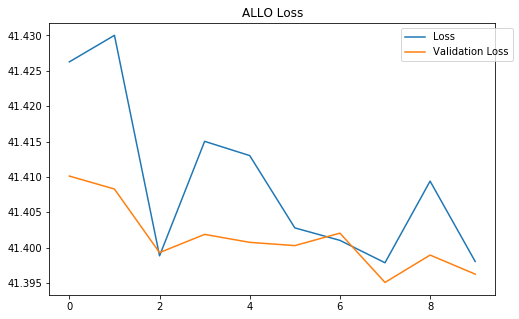

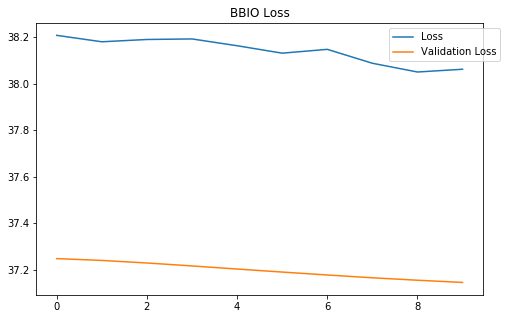

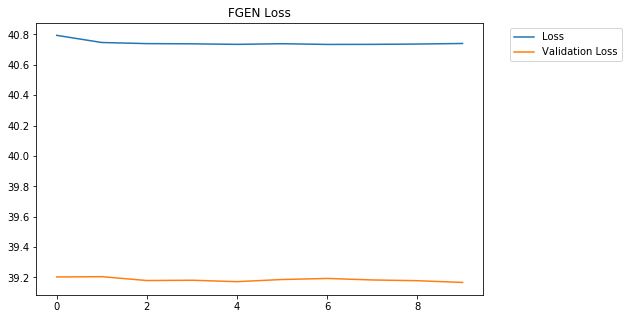

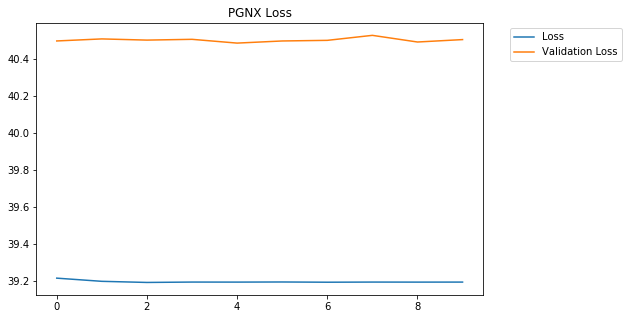

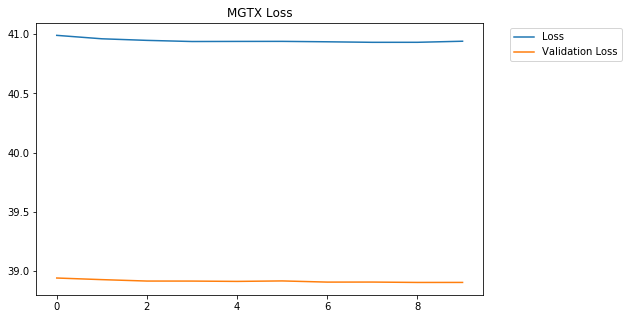

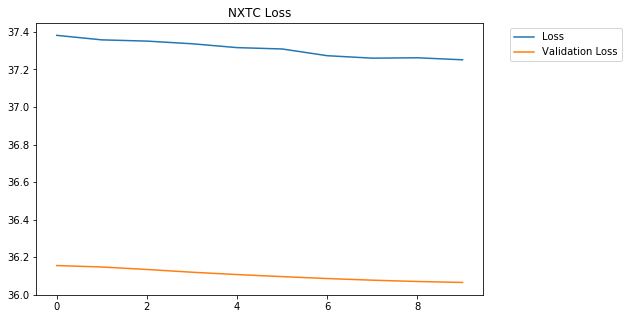

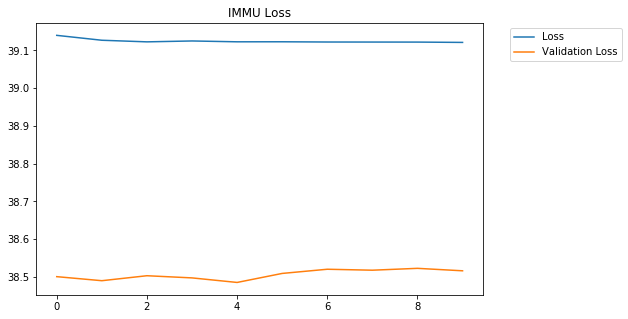

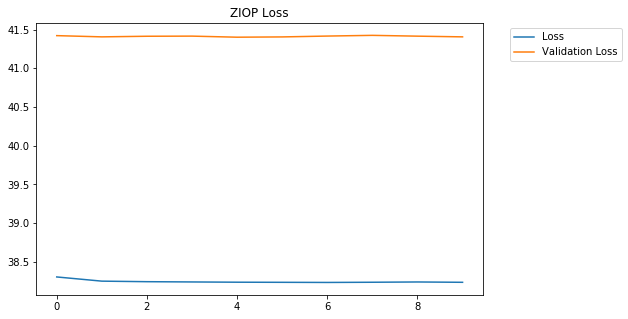

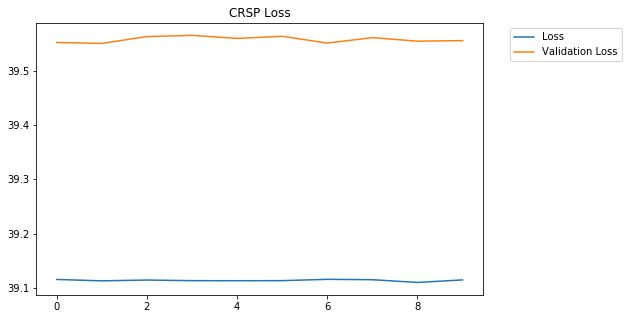

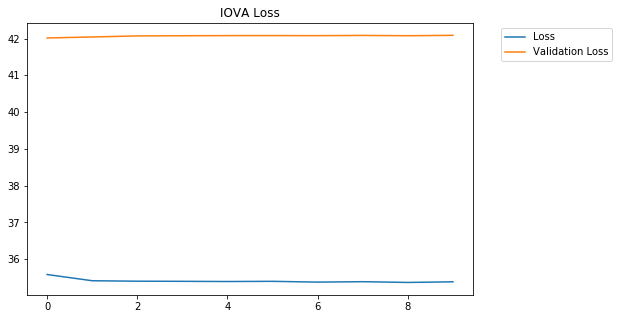

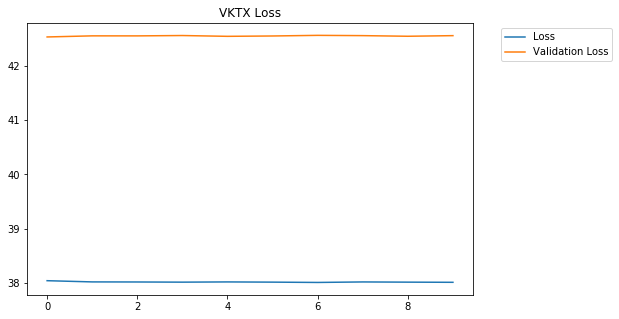

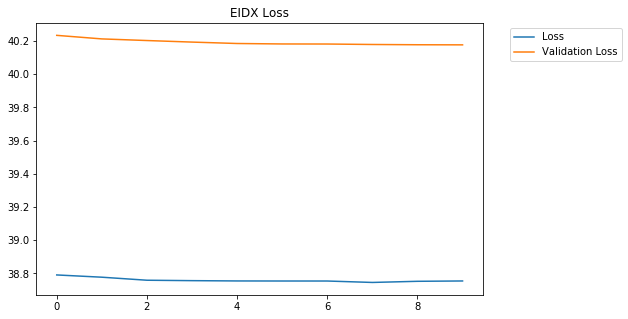

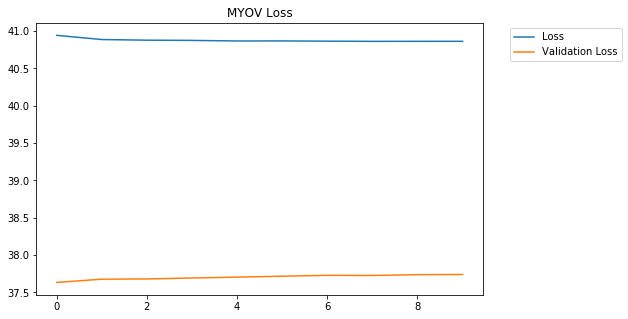

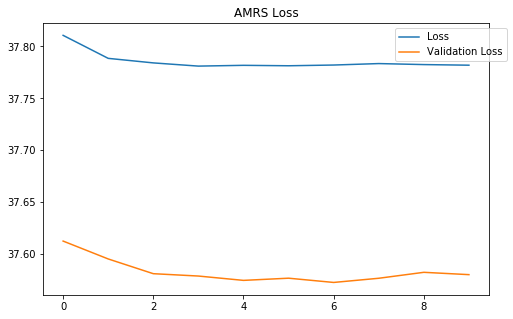

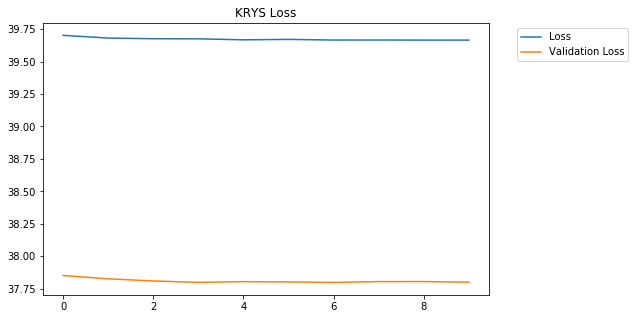

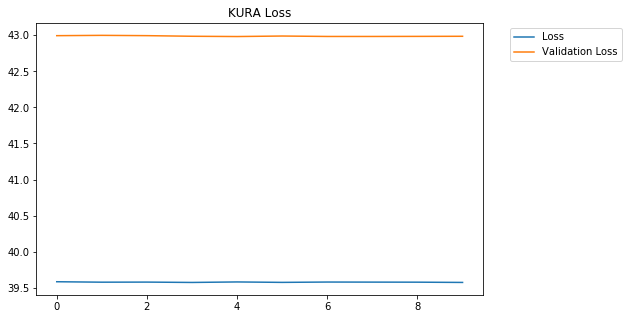

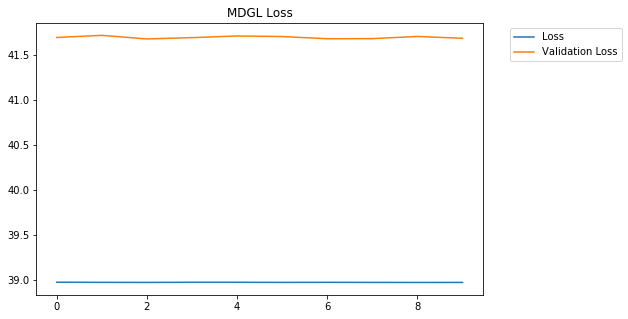

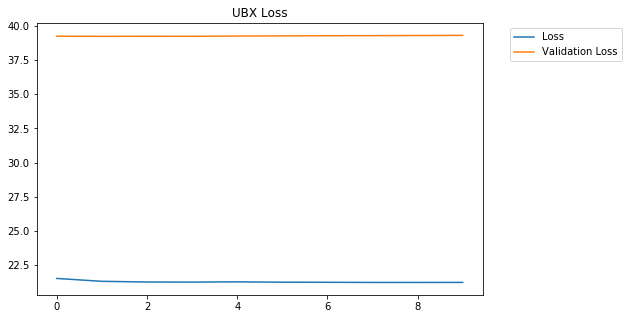

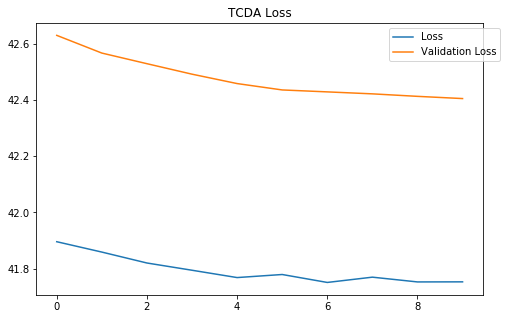

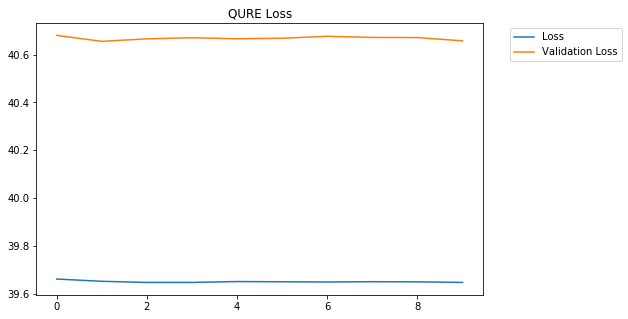

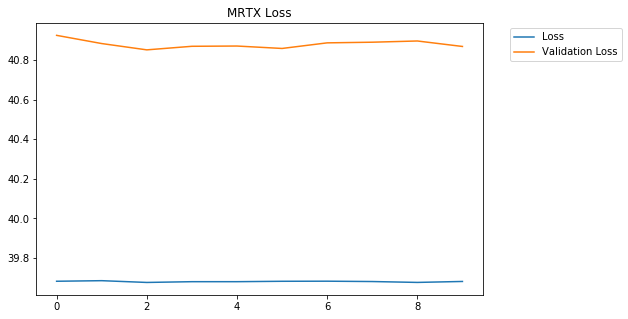

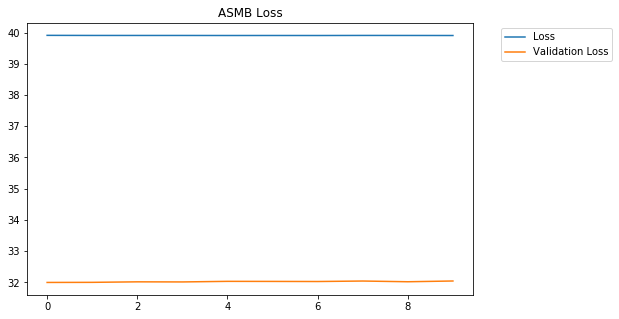

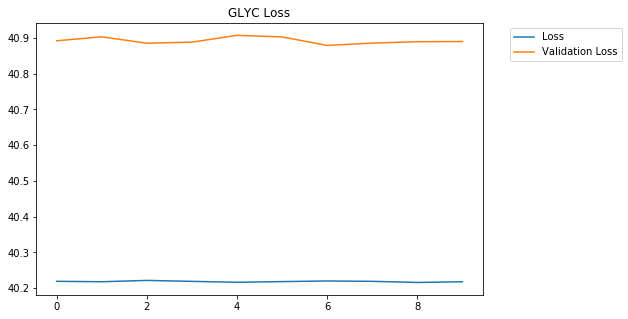

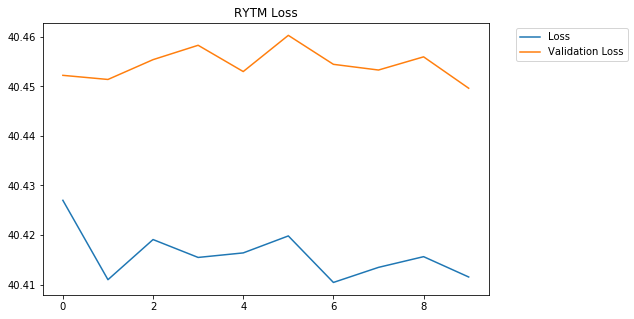

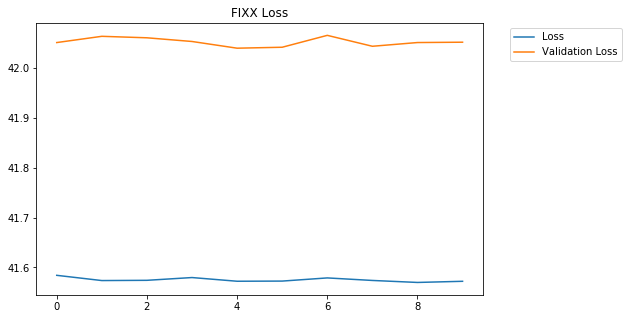

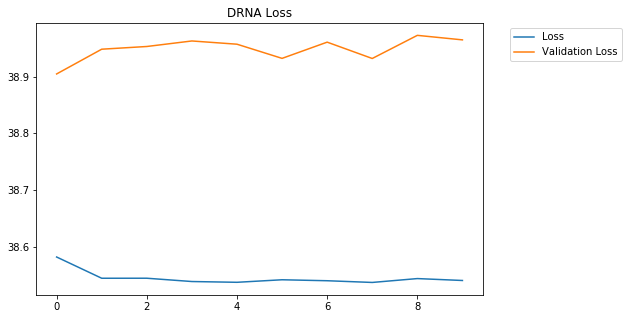

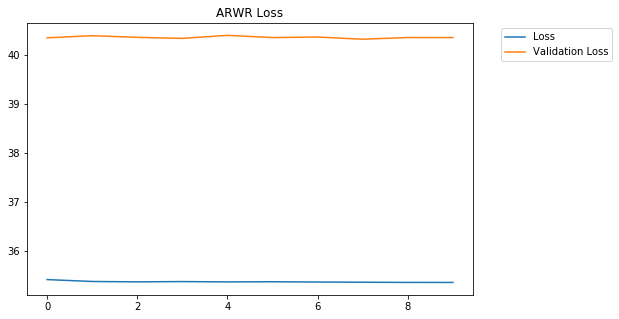

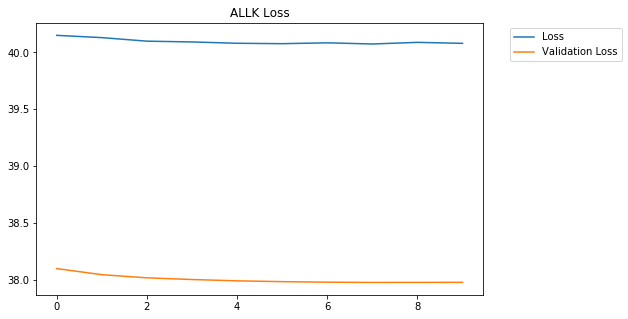

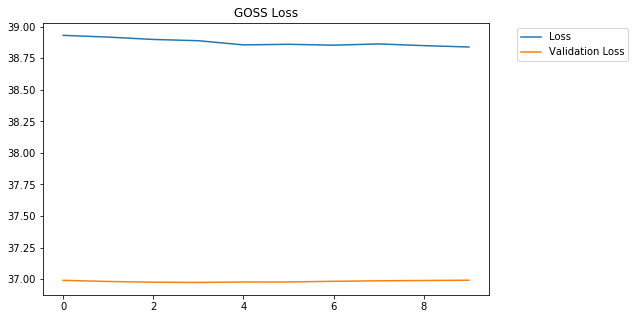

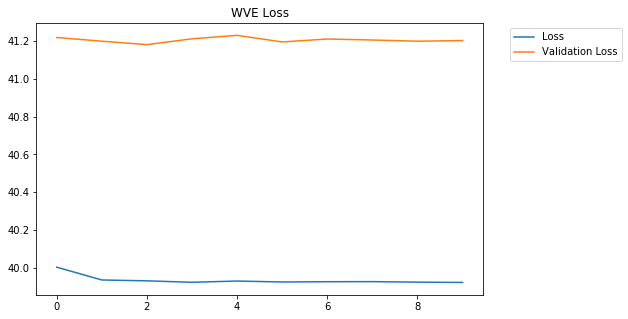

In [56]:
for stock in stocks:

  (feature_train, label_train, feature_test, label_test) = (processed_data[stock]['data_1'],processed_data[stock]['target_1'], 
                                                            processed_data[stock]['data_test'], processed_data[stock]['target_test']) 
  new_model.fit(feature_train, label_train, batch_size=25, epochs=10, validation_data = (feature_test, label_test), verbose=0)
  dict_ = new_model.history.history
  plt.figure(figsize=(8,5))
  plt.title(f"{stock} Loss")
  plt.plot(dict_['loss'], label = 'Loss')
  plt.plot(dict_['val_loss'], label= 'Validation Loss')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()

  plt.figure(figsize=(8,5))
  plt.title(f"{stock} Accuracy")
  plt.plot(dict_['acc'], label = 'Accuracy')
  plt.plot(dict_['val_acc'], label= 'Validation Accuracy')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.show()

In [0]:
stock = 'SGMO'
(feature_train, label_train, feature_test, label_test) = (processed_data[stock]['data_1'],processed_data[stock]['target_1'], 
                                                            processed_data[stock]['data_test'], processed_data[stock]['target_test']) 
new_model.fit(feature_train, label_train, batch_size=25, epochs=2000, validation_data = (feature_test, label_test))
dict_ = new_model.history.history
plt.figure(figsize=(8,5))
plt.title(f"{stock} Loss")
plt.plot(dict_['loss'], label = 'Loss')
plt.plot(dict_['val_loss'], label= 'Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

plt.figure(figsize=(8,5))
plt.title(f"{stock} Accuracy")
plt.plot(dict_['acc'], label = 'Accuracy')
plt.plot(dict_['val_acc'], label= 'Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Train on 4900 samples, validate on 50 samples
Epoch 1/2000
4900/4900 [==============================] - 2s 378us/step - loss: 38.5382 - acc: 0.0286 - val_loss: 41.8714 - val_acc: 0.1000
Epoch 2/2000
4900/4900 [==============================] - 2s 370us/step - loss: 38.5376 - acc: 0.0414 - val_loss: 41.8842 - val_acc: 0.1000
Epoch 3/2000
4900/4900 [==============================] - 2s 368us/step - loss: 38.5387 - acc: 0.0329 - val_loss: 41.8158 - val_acc: 0.0000e+00
Epoch 4/2000
4900/4900 [==============================] - 2s 359us/step - loss: 38.5379 - acc: 0.0361 - val_loss: 41.8916 - val_acc: 0.1000
Epoch 5/2000
4900/4900 [==============================] - 2s 365us/step - loss: 38.5377 - acc: 0.0335 - val_loss: 41.8448 - val_acc: 0.0400
Epoch 6/2000
4900/4900 [==============================] - 2s 368us/step - loss: 38.5383 - acc: 0.0298 - val_loss: 41.8687 - val_acc: 0.1000
Epoch 7/2000
4900/4900 [==============================] - 2s 366us/step - loss: 38.5382 - acc: 0.0380 - val_lo

In [0]:
new_model.save('GRU_1_Day.h5')

In [0]:
with open('train_test.json', 'w') as file:
  json.dump(data, file)

In [0]:
with open('train_test.json', 'r') as file1:
  re = json.load(file1)

In [53]:
re.keys()

dict_keys(['ITCI', 'AXSM', 'CVM', 'KRTX', 'APLS', 'PRVB', 'CRTX', 'EPZM', 'CRBP', 'CCXI', 'TGTX', 'IMGN', 'FATE', 'AKBA', 'DNLI', 'RIGL', 'PRNB', 'ARVN', 'ZYME', 'MRNA', 'CYTK', 'FTSV', 'ASND', 'XBIT', 'ALEC', 'ORTX', 'ADVM', 'MGNX', 'AKRO', 'ESPR', 'BHVN', 'YMAB', 'RGNX', 'MYOK', 'TPTX', 'ATNX', 'BLUE', 'AGEN', 'AVRO', 'DCPH', 'CTMX', 'SRNE', 'ARDX', 'BCRX', 'RETA', 'KOD', 'DTIL', 'RARX', 'AUTL', 'GTHX', 'CARA', 'KDMN', 'XNCR', 'ACHN', 'ARNA', 'RCKT', 'TBIO', 'VYGR', 'SGMO', 'ODT', 'ANAB', 'ATRA', 'CNST', 'GERN', 'BPMC', 'ALLO', 'BBIO', 'FGEN', 'PGNX', 'MGTX', 'NXTC', 'IMMU', 'ZIOP', 'CRSP', 'IOVA', 'VKTX', 'EIDX', 'MYOV', 'AMRS', 'KRYS', 'KURA', 'MDGL', 'UBX', 'TCDA', 'QURE', 'MRTX', 'ASMB', 'GLYC', 'RYTM', 'FIXX', 'DRNA', 'ARWR', 'ALLK', 'GOSS', 'WVE'])

In [55]:
re['ITCI'][0].keys()

dict_keys(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Date', 'Low_1', 'Max_1', 'Low_3', 'Max_3', 'Low_10', 'Max_10', 'Low_30', 'Max_30', 'Ticker', 'Low_1_under_bin', 'Low_1_over_bin', 'Low_1_-0.1', 'Low_1_-0.09', 'Low_1_-0.08', 'Low_1_-0.07', 'Low_1_-0.06', 'Low_1_-0.05', 'Low_1_-0.04', 'Low_1_-0.03', 'Low_1_-0.02', 'Low_1_-0.01', 'Low_1_0.0', 'Low_3_under_bin', 'Low_3_over_bin', 'Low_3_-0.1', 'Low_3_-0.09', 'Low_3_-0.08', 'Low_3_-0.07', 'Low_3_-0.06', 'Low_3_-0.05', 'Low_3_-0.04', 'Low_3_-0.03', 'Low_3_-0.02', 'Low_3_-0.01', 'Low_3_0.0', 'Low_10_under_bin', 'Low_10_over_bin', 'Low_10_-0.1', 'Low_10_-0.09', 'Low_10_-0.08', 'Low_10_-0.07', 'Low_10_-0.06', 'Low_10_-0.05', 'Low_10_-0.04', 'Low_10_-0.03', 'Low_10_-0.02', 'Low_10_-0.01', 'Low_10_0.0', 'Low_30_under_bin', 'Low_30_over_bin', 'Low_30_-0.1', 'Low_30_-0.09', 'Low_30_-0.08', 'Low_30_-0.07', 'Low_30_-0.06', 'Low_30_-0.05', 'Low_30_-0.04', 'Low_30_-0.03', 'Low_30_-0.02', 'Low_30_-0.01', 'Low_30_0.0', 'Max_1_under_bin',